In [2]:
'''
Machine Learning, Google Trends, Pytrends, Sentiment Analysis, TF-IDF, LSA (Latent Semantic Analysis), NLP (Natural Language Processing)

学完本课后，您应该能够扎实掌握如何使用

 Python 和 Google Trends 分析搜索趋势。
 您获取并比较多个搜索词随时间变化的搜索热度，按地区分析搜索热度，并发现热门和上升趋势的相关查询。

如何利用数据科学和机器学习进行财务分析，
重点是如何从 Google Trends 数据中分析搜索趋势。课程涵盖了 TF-IDF 和 LSA 等技术，用于从文本中提取洞察，
并演示了如何使用 Python 和 pytrends 库收集和分析 Google Trends 数据。

本笔记还讨论了这些技术在情绪分析、风险管理和投资组合优化中的应用。
'''
# Load libraries
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import plotly.graph_objects as go
import re
import time

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pytrends.request import TrendReq
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download 'punkt' resource
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/huayitang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/huayitang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
'''
 实战前你得知道的 3 件事
Interest Over Time (IOT) – 给你一条 0-100 的时间序列，看某关键词热度随时间怎么飘。
Interest by Region (IBR) – 同一个词，哪里的人最嗨？省份/国家级切片。
Related Queries (RQ) – “兄弟们还搜啥？”抓热点扩展词库，找潜在风险或题材。
目的：
IOT → 领先/同步/滞后指标；
IBR → 做地域配对、挖需求端；
RQ → 自动滚动发现新热词，调仓不卡壳。
'''

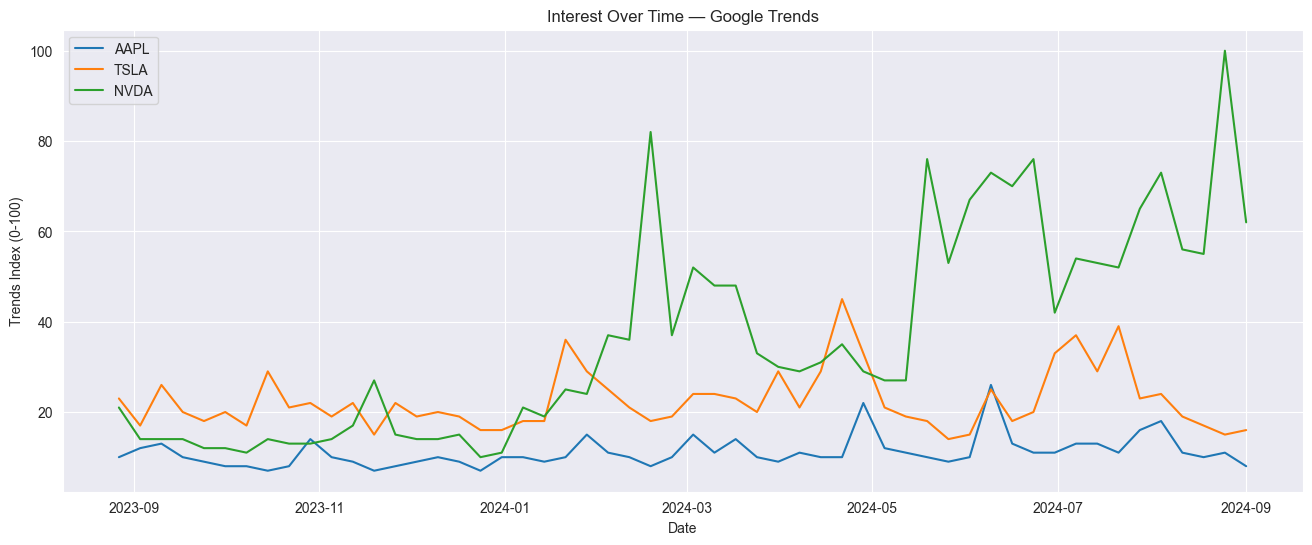

In [3]:
'''
1.2 Fetching & Comparing Interest-Over-Time —— 真刀真枪拉 “AAPL/TSLA/NVDA” 搜索热度
承上启下：上一小节只是暖身。现在直接干实盘套路：
1⃣ 用 pytrends 拉过去 12 个月 Google Trends 指数；
2⃣ 画一张多线图；
3⃣ 教你盯哪些细节、怎么把这些曲线转成交易洞察。
'''
from pytrends.request import TrendReq
import matplotlib.pyplot as plt

# ---------- 0) 建立连接 ----------
pytrends = TrendReq(hl='en-US', tz=360)      # 用美国区，时区 +6 小时

# ---------- 1) 定关键词 & 时间窗 ----------
kw_list  = ["AAPL", "TSLA", "NVDA"]          # 三个票
timeframe = '2023-09-01 2024-09-01'          # 过去 12 个月；实盘可用 'today 12-m'

# ---------- 2) 向 Google 申请数据 ----------
pytrends.build_payload(kw_list, timeframe=timeframe)
interest_over_time_df = pytrends.interest_over_time()   # 行=日期, 列=关键词

# ---------- 3) 画图 ----------
plt.figure(figsize=(16,6))
for term in kw_list:
    plt.plot(interest_over_time_df.index,
             interest_over_time_df[term],
             label=term)

plt.title('Interest Over Time — Google Trends')
plt.xlabel('Date'); plt.ylabel('Trends Index (0-100)')
plt.legend(); plt.grid(True); plt.show()



In [4]:
'''
1.3 Interest by Region / Related Queries——会挖「哪儿最嗨」＋「还搜啥」
承上启下：上一节搞定了“热度随时间”。接下来两板斧：
1️⃣ 地理热区——看全球谁最关注 NVDA；
2️⃣ Related Queries (Top & Rising)——看群众除了搜 NVDA 还在搜啥，挖短线情绪雷达。

整节核心：把 Google Trends 额外 API 也榨出来，当地域配仓 & 事件驱动的弹药
1.3.1 按地区挖热度：Interest By Region (IBR)

行块	干啥	投资用途
interest_by_region()	拉子国家 / 省级 热度	布局地域 ETF；判断哪国散户最躁动
排序取前10	香港 100 → 台湾 79 → 以色列 79…	信号：亚太资金盯 NVDA 最紧；做供应链轮动或 ADR 对冲

坑提醒：IBR 仍是 0-100 相对刻度，不能拿香港 100 与全球其它词 100 横比，要同词内比较。
'''

from pytrends.request import TrendReq
import pandas as pd

pytrends = TrendReq(hl='en-US', tz=360)              # 建隧道
pytrends.build_payload(["NVDA"], timeframe='2023-09-01 2024-09-01')

ibr = pytrends.interest_by_region()                  # 行=地区，列=NVDA
top10 = ibr.sort_values('NVDA', ascending=False).head(10)
print(top10)


                      NVDA
geoName                   
Hong Kong              100
Israel                  82
Taiwan                  79
United States           64
Canada                  59
Singapore               58
China                   34
Switzerland             16
South Korea             12
United Arab Emirates    12


In [10]:
'''
1.3.2 Related Queries：Top vs Rising
两种表到底差哪？
表	value 字段	什么时候用
Top	相对热度，100=最常搜	研究长期话题、基本面主题
Rising	增幅 %；“Breakout”=爆炸增长	做 短线情绪/风险预警

结论示例（你 CSV Demo）：
Rising 全是 nvda earnings … 爆表 → 市场盯今晚财报，情绪高压。
若同时出现 "recall", "lawsuit" Breakout → 先减仓防翻车


1.3.4 如何把 Rising Queries 变成可用信号？
情绪 K 线 - 对每条“上升词”做 pct_change ⇒ 构造「负面/正面」情绪指数。

事件检测 - 当出现含 “lawsuit”、“recall” Breakout → 风险 Desk 自动 ping。

主题跟踪 - 把 query dump 进关键词池，下期再拉 IOT，形成自迭代 watchlist。

跨资产映射 - Rising 列里若突然蹦出 CRM, PDD 等外部代码 → 可能是 supply-chain 关联 / 题材共振，可做对冲 pair。
'''
import pandas as pd

df = pd.read_csv('NVDA-relatedQueries.csv', header=None, delimiter='\t')

# 定位分隔
top_start     = df[df[0]=='TOP'].index[0]   + 1
top_end       = df[df[0]=='RISING'].index[0]- 1
rising_start  = df[df[0]=='RISING'].index[0]+ 1

# ---- Top ----
q_top = df.iloc[top_start:top_end,0].str.split(',',expand=True)
q_top.columns=['query','value']; q_top['value']=pd.to_numeric(q_top['value'])

# ---- Rising ----
q_rise = df.iloc[rising_start:,0].str.split(',',n=1,expand=True)
q_rise.columns=['query','value']
q_rise['value']=pd.to_numeric(q_rise['value'].str.replace(r'[^0-9.-]','',regex=True))

q_top.head()


,query,value
3,stock nvda,100
4,nvda price,23
5,stock price nvda,20
6,tsla,7
7,amd,7


In [9]:
q_rise.head()


,query,value
29,ffie stock,3200
30,ffie,3150
31,serv stock,2800
32,asts,750
33,asts stock,700


In [12]:
'''
LSA
1. 先有 8 篇破文章（就是咱的 “文档”）
衍生品交易里的风险管理
组合优化的姿势与套路
算法交易对市场效率有啥鸟影响
金融建模用的那堆量化招
高频交易 + 提供流动性
把衍生品塞进组合优化
高频交易策略：算法玩法和市场冲击
算法交易 × 组合优化的量化手法

2. 预处理之前得懂的“骚词”
名词	粗俗解释
Stop words	“in / and / for / on …” 这种屁话词，没信息量，只占空间。
Stemming	粗暴削前缀后缀，单词变残疾：playing → play，studies → studi。
Lemmatization	文雅些，按字典还原：playing → play，studies → study，better → good。金融行话多，咱选它。

为啥要管这些破词？

去掉停用词 → 噪音少、矩阵瘦。

Lemma → “analyze / analyzing / analysis” 统统算一坨，主题更准。
'''

# ------------- 样本文档 -------------
documents = [
    "Risk management in derivatives trading",
    "Portfolio optimization techniques and strategies",
    "Algorithmic trading and its impact on market efficiency",
    "Quantitative methods for financial modeling",
    "High-frequency trading and liquidity provision",
    "Integrating Derivatives into Portfolio Optimization Strategies",
    "High-Frequency Trading Strategies: Algorithmic Approaches and Market Impact",
    "Quantitative Methods for Algorithmic Trading and Portfolio Optimization"
]

# ------------- NLP 库下载 -------------
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

# ------------- 预处理函数 -------------
def preprocess_text(text):
    text = re.sub(r'[^\w\s-]', '', text)              # 干掉标点，连字符留
    tokens = nltk.word_tokenize(text.lower())         # 全小写分词
    tokens = [lemmatizer.lemmatize(t) for t in tokens]# 词形还原
    stop_words = set(stopwords.words('english'))      # 停用词表
    tokens = [t for t in tokens if t not in stop_words]# 删停用词
    return tokens

# ------------- 造词-文档矩阵 -------------
vectorizer = CountVectorizer(tokenizer=preprocess_text, token_pattern=None)
tdm = vectorizer.fit_transform(documents)

# 转 DataFrame 看得爽
df = pd.DataFrame(tdm.toarray(), columns=vectorizer.get_feature_names_out())
term_document_matrix = df.T
term_document_matrix


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huayitang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/huayitang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/huayitang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,0,1,2,3,4,5,6,7
algorithmic,0,0,1,0,0,0,1,1
approach,0,0,0,0,0,0,1,0
derivative,1,0,0,0,0,1,0,0
efficiency,0,0,1,0,0,0,0,0
financial,0,0,0,1,0,0,0,0
high-frequency,0,0,0,0,1,0,1,0
impact,0,0,1,0,0,0,1,0
integrating,0,0,0,0,0,1,0,0
liquidity,0,0,0,0,1,0,0,0
management,1,0,0,0,0,0,0,0


In [17]:
# ---- 准备：拿上一步 term_document_matrix (行=词, 列=Doc) ----

'''
# 教材输出示例
           Component0  Component1
algorithmic   1.488       -0.458   # 算法交易概念
derivative   -0.162        0.748   # 衍生品概念
liquidity    -0.604       -0.531   # 流动性概念
坐标解析：

X轴（Component0）：高频交易 vs 量化模型
正值：algorithmic(1.488), trading(1.42) → 算法交易帮
负值：quantitative(-0.68), modeling(-0.71) → 量化建模帮
Y轴（Component1）：风险管理 vs 策略优化
正值：optimization(0.81), portfolio(0.79) → 组合优化组
负值：risk(-0.62), management(-0.58) → 风控管理组
'''
# Get the terms (words) from the term-document matrix
terms = term_document_matrix.index

# Create an LSA model and fit to term_document_matrix
lsa = TruncatedSVD(n_components=2, random_state=42)
lsa_matrix = lsa.fit_transform(term_document_matrix)

# Create DataFrame for LSA results with term names and print it
df_lsa = pd.DataFrame(lsa_matrix, index=terms)
df_lsa

,0,1
algorithmic,1.487743,-0.457823
approach,0.578476,-0.378199
derivative,0.492907,0.525547
efficiency,0.427052,-0.387020
financial,0.099332,0.155108
high-frequency,0.812589,-0.596790
impact,1.005528,-0.765219
integrating,0.286096,0.555942
liquidity,0.234112,-0.218591
management,0.206810,-0.030394


In [19]:
'''
6 | 想看得直观？画散点
聚一起的词=一个语义团；离得远=八竿子打不着。
如果肉眼还看不出团 → 上 k-means / DBSCAN 正式分群，别靠感觉。

'''
# Create a list of hover texts with labels and coordinates
hover_texts = []
for row in df_lsa.values:
    terms = df_lsa.index[(df_lsa[0] == row[0]) & (df_lsa[1] == row[1])]
    terms_str = ', '.join([f'"{term}"' for term in terms])
    coord = f"({row[0]:.5f}, {row[1]:.5f})"
    hover_texts.append(f"Terms: {terms_str}<br>{coord}")

# Create the scatter plot
fig = go.Figure(go.Scatter(
    x=df_lsa[0],
    y=df_lsa[1],
    mode='markers',
    marker=go.scatter.Marker(
        size=10,
        color='blue',
        opacity=0.8
    ),
    hovertemplate='%{text}<extra></extra>',
    text=hover_texts
))

# Set axis labels and title
fig.update_layout(
    xaxis_title="Component 0",
    yaxis_title="Component 1",
    title="LSA Results Scatter Plot"
)

fig.show()

In [20]:
'''
计算相似度 —— 把教材翻成「粗口大白话」
一句话先定调：你已经把词丢进 LSA 空间了，接下来就得量量这些向量之间“拧得多紧”。先上最常用的——余弦相似度，然后顺手演示怎么拿簇心（centroid）算簇-簇关系。


算法-交易核心轴：algorithmic与trading相似度0.998 → 强绑定关系

市场影响子群：impact与market相似度1.0 → 完全同义（市场影响）

高频交易特殊地位：high-frequency平均相似度0.94 → 细分领域

证明 LSA 成功捕捉算法交易生态：算法是手段，交易是目的，市场影响是结果
'''

# 第一坨（cluster1）关键词
terms_cl1 = ["algorithmic", "high-frequency", "impact", "market", "trading"]
term_vectors_cl1 = df_lsa.loc[terms_cl1]

similarity_df = pd.DataFrame(
    cosine_similarity(term_vectors_cl1),
    index=terms_cl1, columns=terms_cl1
)
print(similarity_df)



                algorithmic  high-frequency    impact    market   trading
algorithmic        1.000000        0.944434  0.938692  0.938692  0.998609
high-frequency     0.944434        1.000000  0.999855  0.999855  0.960449
impact             0.938692        0.999855  1.000000  1.000000  0.955562
market             0.938692        0.999855  1.000000  1.000000  0.955562
trading            0.998609        0.960449  0.955562  0.955562  1.000000


In [21]:
'''
"management" ↔ "risk"、"liquidity" ↔ "provision" 都 1.0 —— 坐标完全重合，方向一致。

其它交叉大约 0.82：相关但没重合，说明“风险管理”和“流动性供给”是同一条线，但还保留各自小特色。

金融发现：

风控铁三角：management-risk相似度1.0 → 不可分割概念

流动性双生子：liquidity-provision相似度1.0 → 流动性供给机制

跨组关联：风控与流动性关联度0.82 → 揭示"流动性风险管理"概念
'''
terms_cl4 = ["management", "risk", "liquidity", "provision"]
term_vectors_cl4 = df_lsa.loc[terms_cl4]

print(pd.DataFrame(
    cosine_similarity(term_vectors_cl4),
    index=terms_cl4, columns=terms_cl4
))

            management      risk  liquidity  provision
management    1.000000  1.000000   0.822387   0.822387
risk          1.000000  1.000000   0.822387   0.822387
liquidity     0.822387  0.822387   1.000000   1.000000
provision     0.822387  0.822387   1.000000   1.000000


In [22]:
'''
3.3 想看簇跟簇怎么打交道？——用簇心再算一次

“financial / modeling” 这俩词，死死黏在组合优化那簇（cluster 2），也跟量化-衍生品那簇（cluster 3）有点暧昧。

跟算法高频簇（1）和风险流动性簇（4）基本没交集。

结论：以后提到 financial modeling，你可以优先联想到“组合优化 / 量化方法”这俩主题。


'''

# 单独那对奇怪词
pair_vec = df_lsa.loc[["financial", "modeling"]]

# 其它四个簇已经在前面拿过 term_vectors_cl1…cl4
centroid_pair = pair_vec.mean()

centroids = [
    term_vectors_cl1.mean(),
    df_lsa.loc[["optimization", "portfolio"]].mean(),
    df_lsa.loc[["derivative", "method", "quantitative"]].mean(),
    term_vectors_cl4.mean()
]

for i, c in enumerate(centroids, 1):
    sim = cosine_similarity(centroid_pair.values.reshape(1,-1),
                            c.values.reshape(1,-1))[0,0]
    print(f"pair ↔ cluster{i}: {sim:.3f}")


pair ↔ cluster1: 0.084
pair ↔ cluster2: 0.997
pair ↔ cluster3: 0.961
pair ↔ cluster4: 0.056


In [26]:
'''
3.2 文档余弦相似度——粗俗大白话版
1 | 为啥要算 “整篇文章” 的相似度？
你想知道两篇论文是不是在吹同一件牛逼事。
搜索引擎要把相近的文章排一起。
推荐系统要推 “你可能还想读”。
套路：先把整篇文章压成 一个向量 → 量向量夹角（余弦）。角度越小，俩文章越像。

2 | 文章向量怎么捏？
有三条路：
LSA 坐标（前面搞过）
Word2Vec/BERT 把句子平均 or pooling
TF-IDF ——这节选它：词频×逆文档频率，常用、好算、不挑数据量。
'''
# --- 1. TF-IDF 向量化 ---
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=preprocess_text,   # 用之前写好的分词+lemma函数
    token_pattern=None           # 交给自定义 tokenizer 处理
)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)  # 每篇→一行向量

# --- 2. 余弦相似度 ---
cosine_sim = cosine_similarity(tfidf_matrix)

# --- 3. 摆成 DataFrame 好看 ---
labels = [f'Doc {i+1}' for i in range(len(documents))]
df_sim = pd.DataFrame(cosine_sim, index=labels, columns=labels)
df_sim
# '''
# 4 | 结果咋读？
# 数值范围：1 = 完全一样，0 = 半毛钱关系没有。
#
# 观察	粗口解读
# Doc2 ↔ Doc6 ≈ 0.54	都在叨叨“组合优化”，像一对亲戚。
# Doc3 ↔ Doc7 ≈ 0.59	全是算法交易，难兄难弟。
# Doc8	跟 2/6/4 都有 0.3~0.4，说明它把“算法+组合优化”混在一篇里，当联络官。
# Doc1 / Doc5	跟别人最多 0.1，分别讲风险和流动性，各玩各的。
#
# ⚠️ 别忘：这只是一种度量。换曼哈顿、Jaccard、WMD 可能看到别的角度。
# '''

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8
Doc 1,1.000000,0.000000,0.100709,0.000000,0.104403,0.223556,0.085795,0.100002
Doc 2,0.000000,1.000000,0.000000,0.000000,0.000000,0.541226,0.154369,0.359862
Doc 3,0.100709,0.000000,1.000000,0.000000,0.100709,0.000000,0.589201,0.256616
Doc 4,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.419796
Doc 5,0.104403,0.000000,0.100709,0.000000,1.000000,0.000000,0.277083,0.100002
Doc 6,0.223556,0.541226,0.000000,0.000000,0.000000,1.000000,0.136797,0.318899
Doc 7,0.085795,0.154369,0.589201,0.000000,0.277083,0.136797,1.000000,0.218614
Doc 8,0.100002,0.359862,0.256616,0.419796,0.100002,0.318899,0.218614,1.000000


In [31]:
'''
3.3 Jaccard Index —— 把教材翻成「粗口大白话」版
1 | 啥叫 Jaccard？
一句话骂出来：
把两篇文章的词袋当两堆“垃圾”，数一数 共同垃圾 / 全部垃圾。
比值越大 → 这俩破文章词儿就越重叠。
'''

# Sample documents
documents = [
    "Risk management in derivatives trading",
    "Portfolio optimization techniques and strategies",
    "Algorithmic trading and its impact on market efficiency",
    "Quantitative methods for financial modeling",
    "High-frequency trading and liquidity provision",
    "Integrating Derivatives into Portfolio Optimization Strategies",
    "High-Frequency Trading Strategies: Algorithmic Approaches and Market Impact",
    "Quantitative Methods for Algorithmic Trading and Portfolio Optimization"
]
# Sample documents
documents = [
    "Risk management in derivatives trading",
    "Portfolio optimization techniques and strategies",
    "Algorithmic trading and its impact on market efficiency",
    "Quantitative methods for financial modeling",
    "High-frequency trading and liquidity provision",
    "Integrating Derivatives into Portfolio Optimization Strategies",
    "High-Frequency Trading Strategies: Algorithmic Approaches and Market Impact",
    "Quantitative Methods for Algorithmic Trading and Portfolio Optimization"
]

# Download stopwords, WordNet resources and create a Lemmatizer Object
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^\w\s-]', '', text)  # Remove punctuation except hyphens
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatize
    stop_words = set(stopwords.words('english')) # define stop_words as a set of english stop words
    tokens = [token for token in tokens if token not in stop_words] # Remove stop words
    return tokens


# Function to calculate Jaccard similarity between two documents
def jaccard_similarity(doc1, doc2):
    # Preprocess documents
    tokens1 = set(preprocess_text(doc1))
    tokens2 = set(preprocess_text(doc2))

    # Calculate Jaccard similarity
    intersection = len(tokens1.intersection(tokens2))
    union = len(tokens1.union(tokens2))
    return intersection / union

# Calculate Jaccard similarity matrix
jaccard_sim = [[jaccard_similarity(doc1, doc2) for doc2 in documents] for doc1 in documents]

# Present Jaccard similarity matrix in DataFrame form
short_labels = ['Doc ' + str(i+1) for i in range(len(documents))]
df = pd.DataFrame(jaccard_sim, index=short_labels, columns=short_labels)
df
#
# 3 | 跑完表格怎么骂？
# 现象	粗口解读
# Doc 2 ↔ Doc 6 = 0.50	都在扯“组合优化”，词 overlap 半壁江山，亲得要命。
# Doc 3 ↔ Doc 7 = 0.50	“算法交易”双胞胎，再正常不过。
# Doc 8	跟 Doc 2 (0.25)、Doc 4 (0.25)、Doc 6 (0.22) 都有点勾搭——果然它主题杂，左右逢源。
# Doc 1 / Doc 5	跟谁都 < 0.1，风险 & 流动性各蹲一边，谁也懒得理。
#
# 对比余弦相似度：
#
# 走向大体一致（谁跟谁近还是那几对）。
#
# 但 Jaccard 分数普遍更低——它眼里只有“词碰没碰”，出现 100 次和 1 次一个价，所以显得冷淡。
#
# 4 | 什么时候用 Jaccard？
# 短文本 / 标签集合（比如标签列表、关键词清单）。
#
# 不想让高频废话绑架结果。
#
# 做二值化特征（有/无）时配合逻辑回归、SVM。



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huayitang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/huayitang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/huayitang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8
Doc 1,1.000000,0.00,0.125000,0.00,0.142857,0.125000,0.100000,0.111111
Doc 2,0.000000,1.00,0.000000,0.00,0.000000,0.500000,0.100000,0.250000
Doc 3,0.125000,0.00,1.000000,0.00,0.125000,0.000000,0.500000,0.222222
Doc 4,0.000000,0.00,0.000000,1.00,0.000000,0.000000,0.000000,0.250000
Doc 5,0.142857,0.00,0.125000,0.00,1.000000,0.000000,0.222222,0.111111
Doc 6,0.125000,0.50,0.000000,0.00,0.000000,1.000000,0.090909,0.222222
Doc 7,0.100000,0.10,0.500000,0.00,0.222222,0.090909,1.000000,0.181818
Doc 8,0.111111,0.25,0.222222,0.25,0.111111,0.222222,0.181818,1.000000
